In [1]:
# Importing the required packages/libraries

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time

from sklearn import metrics as skmetrics

# Fixing the ramdom seeds for reproducibility

torch.manual_seed(0)
np.random.seed(0)

# Building and Training the model

The following code blocks build, train, and evaluate the ML model.

In [2]:
# This code block defines the ML model architecture

class neural_network_model(nn.Module):
    
    def __init__(self, tensor_len, num_classes):
        
        super(neural_network_model, self).__init__()
        # Change these numbers to modify number of hidden neurons in each layer
        self.n_nodes_hl1 = 500
        self.n_nodes_hl2 = 500
        self.n_nodes_hl3 = 500
        
        self.tensor_len = tensor_len
        self.num_classes = num_classes
        
        self.hidden_1_layer = nn.Linear(self.tensor_len, self.n_nodes_hl1)
        nn.init.normal_(self.hidden_1_layer.weight)
        nn.init.normal_(self.hidden_1_layer.bias)
        
        self.hidden_2_layer = nn.Linear(self.n_nodes_hl1, self.n_nodes_hl2)
        nn.init.normal_(self.hidden_2_layer.weight)
        nn.init.normal_(self.hidden_2_layer.bias)
        
        self.hidden_3_layer = nn.Linear(self.n_nodes_hl2, self.n_nodes_hl3)
        nn.init.normal_(self.hidden_3_layer.weight)
        nn.init.normal_(self.hidden_3_layer.bias)
        
        self.output_layer = nn.Linear(self.n_nodes_hl3, self.num_classes)
        nn.init.normal_(self.output_layer.weight)
        nn.init.normal_(self.output_layer.bias)
        
    def forward(self, data):
        
        data = torch.Tensor(data)
        l1 = F.relu(self.hidden_1_layer(data))
        l2 = F.relu(self.hidden_2_layer(l1))
        l3 = F.relu(self.hidden_3_layer(l2))
        
        output = self.output_layer(l3)
        
        return output

In [3]:
# This code block has the loss function and the function to train the neural network

def loss_fn(logits, target):
    
    target = torch.Tensor(target)
    
    loss = torch.sum(- target * F.log_softmax(logits, -1), -1)
    mean_loss = loss.mean()
    
    return mean_loss

def train_nn(train_x, train_y, test_x, test_y, num_classes=2, tensor_len=16, bat_size=100, num_epochs=10):
    
    model = neural_network_model(tensor_len, num_classes)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = np.zeros(num_epochs)
    test_losses = np.zeros(num_epochs)
    
    for it in range(num_epochs):
        
        epoch_loss = 0
        i = 0
        while i < len(train_x):
            
            start = i
            end = i + bat_size
            batch_x = np.array(train_x[start:end])
            batch_y = np.array(train_y[start:end])

            outputs = model(batch_x)
            loss = loss_fn(outputs, batch_y)
            epoch_loss += loss.item()
            i += bat_size
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        
        outputs_test = model(test_x)
        loss_test = loss_fn(outputs_test, test_y)
        
        train_losses[it] = epoch_loss
        test_losses[it] = loss_test.item()
        
        print(f'In this epoch {it+1}/{num_epochs}, Training loss: {train_losses[it]:.4f}, Test loss: {test_losses[it]:.4f}')
    
    return model

In [4]:
def run(tensor_length, bat_size, num_epochs):
    num_classes = 2
    print("\n\nTraining and Testing Neural Network")

    # Load the training and test sets
    # Change the path according to wherever the .npy files are stored
    train_x = np.load('/home/abhijit/Downloads/Main_Python_Scripts_Used/neural_networks/hair_dryer_l/train_x_hair_dryer_l.npy')
    train_y = np.load('/home/abhijit/Downloads/Main_Python_Scripts_Used/neural_networks/hair_dryer_l/train_y_hair_dryer_l.npy')
    test_x = np.load('/home/abhijit/Downloads/Main_Python_Scripts_Used/neural_networks/hair_dryer_l/test_x_hair_dryer_l.npy')
    test_y = np.load('/home/abhijit/Downloads/Main_Python_Scripts_Used/neural_networks/hair_dryer_l/test_y_hair_dryer_l.npy')
    
    print("Test_x shape is", np.array(test_x).shape)
    model = train_nn(train_x, train_y, test_x, test_y, num_classes, tensor_length, bat_size, num_epochs)
    return model

In [5]:
# This code block has the function to generate adversarial examples (refer the paper for the algorithm)

def make_adversarial_attack(X, target_y, model):    
    
    # Use model in evaluation mode
    model.eval()
    
    # Initialize the adversarial datapoint with the true datapoint
    X_fooling = torch.Tensor(X).clone().detach()
    X_fooling.requires_grad = True

    # Can change the learning rate and max_iter according to preferences
    learning_rate = 35    
    max_iter = 1000
    
    # Loop for gradient ascent
    for i in range(max_iter):
        
        # Getting the score
        score = model(X_fooling)
        
        # Breaking from the loop if fooling is successful
        y_value, current_label = score.data.max(dim=1)        
        
        if current_label == target_y:            
            break
            
        # Extract score for target class
        score_target = score[0, target_y]
        # Perform backprop on score for target class
        score_target.backward()        
        
        # Get gradient of adversarial datapoint
        dx = X_fooling.grad.data
        
        # Normalizing the gradient
        dx = learning_rate * (dx / torch.norm(dx))
        
        # Updating the adversarial datapoint
        X_fooling.data += dx
        
        # Clear the gradients at the end of the iteration
        X_fooling.grad.zero_()        
    
    X_fooling = X_fooling.detach()
    
    return X_fooling

In [6]:
# This block can be considered the "main function"
# The model is trained and evaluated

start_time = time.time()

n_classes = 2
tensor_length=16

batch_size = 100
hm_epochs = 10

print("hair_dryer")

# The variable "model" will have the trained model
model = run(tensor_length, batch_size, hm_epochs)

# Loading the training and test data sets in this block (the previous call was inside a function)
# Change the path according to wherever the .npy files are stored
train_x = np.load('/home/abhijit/Downloads/Main_Python_Scripts_Used/neural_networks/hair_dryer_l/train_x_hair_dryer_l.npy')
train_y = np.load('/home/abhijit/Downloads/Main_Python_Scripts_Used/neural_networks/hair_dryer_l/train_y_hair_dryer_l.npy')
test_x = np.load('/home/abhijit/Downloads/Main_Python_Scripts_Used/neural_networks/hair_dryer_l/test_x_hair_dryer_l.npy')
test_y = np.load('/home/abhijit/Downloads/Main_Python_Scripts_Used/neural_networks/hair_dryer_l/test_y_hair_dryer_l.npy')

# Evaluating the trained model on the test set
with torch.no_grad():

    prediction = model(test_x)
    y_pred = np.argmax(prediction.numpy(), 1)
    y_true = np.argmax(test_y, 1)

    val_correct = np.equal(y_pred, y_true)
    val_accuracy = np.mean(val_correct)
    print("validation accuracy:", val_accuracy)

    precision = skmetrics.precision_score(y_true, y_pred)
    print("Precision", precision)

    recall = skmetrics.recall_score(y_true, y_pred)
    print("Recall", recall)

    f1_score = skmetrics.f1_score(y_true, y_pred)
    print("f1_score", f1_score)

    print("confusion_matrix")
    print(skmetrics.confusion_matrix(y_true, y_pred))
    
print("--- %s seconds ---" % (time.time() - start_time))

hair_dryer


Training and Testing Neural Network
Test_x shape is (1000, 16)
In this epoch 1/10, Training loss: 80167413.2207, Test loss: 220978.0156
In this epoch 2/10, Training loss: 52189949.0527, Test loss: 886899.8125
In this epoch 3/10, Training loss: 40563201.7451, Test loss: 113080.8828
In this epoch 4/10, Training loss: 42966937.2100, Test loss: 816930.6250
In this epoch 5/10, Training loss: 33923987.6982, Test loss: 201485.4844
In this epoch 6/10, Training loss: 33853973.9429, Test loss: 134196.5312
In this epoch 7/10, Training loss: 33121465.3223, Test loss: 287945.0312
In this epoch 8/10, Training loss: 29250475.4431, Test loss: 132553.2969
In this epoch 9/10, Training loss: 30969064.4614, Test loss: 142844.9062
In this epoch 10/10, Training loss: 26234643.3972, Test loss: 267001.1562
validation accuracy: 0.735
Precision 0.8929765886287625
Recall 0.534
f1_score 0.6683354192740927
confusion_matrix
[[468  32]
 [233 267]]
--- 35.41093325614929 seconds ---


# Analysis

The code blocks from here on are used for analysis.

In [7]:
# Generating one adversarial example for PCA projection

test_idx = 1
target_y = 0

X_fooling = make_adversarial_attack(test_x[test_idx].reshape(-1, tensor_length), target_y, model)

scores = model(X_fooling)
new_class = np.argmax(scores.detach().numpy(), 1)

print("True class is: {0}\n".format(np.argmax(test_y[test_idx])))
print("New predicted class is: {0}\n".format(new_class))
print("Target class was: {0}\n".format(target_y))

True class is: 1

New predicted class is: [0]

Target class was: 0



In [8]:
# Finding means of respective classes

# Extracting which indices are labeled as class 1
b = np.nonzero(np.argmax(train_y, 1))

# Creating a new array of all data-points belonging to class 1
features_of_class_1 = train_x[b[0],:]

# Creating a new array of all data-points belonging to class 0
features_of_class_0 = np.delete(train_x, b[0], axis=0)

# Find means of respective classes
mean_class_1 = np.mean(features_of_class_1, axis = 0)
mean_class_0 = np.mean(features_of_class_0, axis = 0)

In [9]:
# Applying PCA

centered_X = train_x - np.mean(train_x, axis=0)
U, S, V = np.linalg.svd(centered_X, full_matrices=False)

n_dimensions = 2
W_2d = V.T[:, 0:n_dimensions]

transformed_1 = (features_of_class_1 - np.mean(features_of_class_1, axis=0)) @ W_2d
transformed_0 = (features_of_class_0 - np.mean(features_of_class_0, axis=0)) @ W_2d

X_fooling_transformed = (X_fooling.numpy() - np.mean(X_fooling.numpy(), axis=0)) @ W_2d

# Sanity check for dimensions
print(transformed_1.shape)
print(transformed_0.shape)

print(X_fooling_transformed.shape)

(4883, 2)
(39652, 2)
(1, 2)


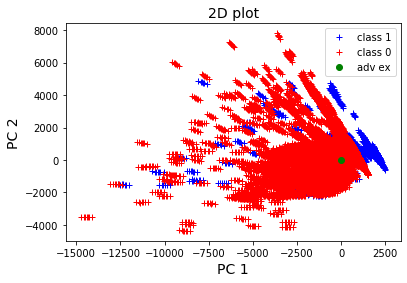

In [10]:
# Making the plots

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(transformed_1[:,[0]], transformed_1[:,[1]], 'b+', label='class 1')
ax.plot(transformed_0[:,[0]], transformed_0[:,[1]], 'r+', label='class 0')

ax.plot(X_fooling_transformed[:,[0]], X_fooling_transformed[:,[1]], 'go', label='adv ex')

ax.legend(loc=0)

ax.set_xlabel('PC 1', fontsize=14)
ax.set_ylabel('PC 2', fontsize=14)
ax.set_title('2D plot', fontsize=14)

plt.show()

In [11]:
# This code block generates adversarial examples for all test datapoints

# This variable is a counter for how many successful adversarial examples were generated
j = 0

X_fooling_saved = []
X_fooling_numpy = []
magnitude_X_fooling = []

for i in range(len(test_x)):
    
    target_y = 1 - np.argmax(test_y[i])    
    
    X_fooling = make_adversarial_attack(test_x[i].reshape(-1, tensor_length), target_y, model)
    
    X_fooling_saved.append(X_fooling)
    X_fooling_numpy.append(np.array(X_fooling.numpy()))
    magnitude_X_fooling.append(np.linalg.norm(X_fooling.numpy(), axis=1))
    
    scores = model(X_fooling)    
    new_class = np.argmax(scores.detach().numpy(), 1)
            
    if new_class == target_y:
        j += 1

In [12]:
# Checking success rate of attacks

print("Succesfully changed classes in {0} test datapoints\n".format(j))

Succesfully changed classes in 1000 test datapoints



In [13]:
# Printing number of training and test datapoints

print(train_x.shape)
print(test_x.shape)

(44535, 16)
(1000, 16)


In [14]:
# Calculating magnitudes of true and adversarial datapoints

magnitude_test_x = np.linalg.norm(test_x, axis=1)
magnitude_X_fooling = np.array(magnitude_X_fooling)

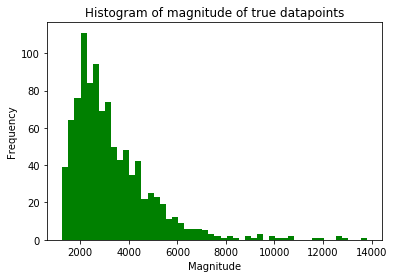

In [15]:
# Plotting histogram for true datapoints

n_1, bins_1, patches_1 = plt.hist(magnitude_test_x, bins=50, color='g')

plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('Histogram of magnitude of true datapoints')
plt.show()

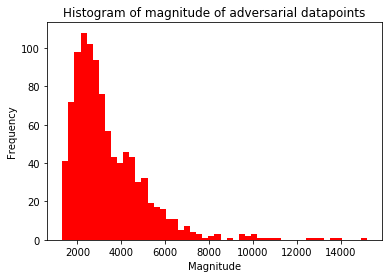

In [16]:
# Plotting histogram for adversarial datapoints

n_2, bins_2, patches_2 = plt.hist(magnitude_X_fooling, bins=50, color='r')

plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('Histogram of magnitude of adversarial datapoints')
plt.show()

In [17]:
# Converting X_fooling_numpy into a numpy array of suitable dimensions
X_fooling_numpy = np.squeeze(np.array(X_fooling_numpy))

# Unit vector
unit_vector = np.full((tensor_length, 1), 1/np.sqrt(tensor_length))

# Dot product of all true datapoints with unit vector
test_dot_prod = np.squeeze(np.dot(test_x, unit_vector))

# Dot product of all adversarial datapoints with unit vector
adv_dot_prod = np.squeeze(np.dot(X_fooling_numpy, unit_vector))

# Magnitude of true datapoints
magnitude_test_x = np.linalg.norm(test_x, axis=1)

# Magnitude of adversarial datapoints
magnitude_X_fooling = np.squeeze(np.array(magnitude_X_fooling))

In [18]:
# Calculating angle with unit vector of true and adversarial datapoints

# Angles of true datapoints with the chosen unit vector
true_angles = np.degrees(np.arccos(test_dot_prod / magnitude_test_x))

# Angles of adversarial datapoints with the chosen unit vector
adv_angles = np.degrees(np.arccos(adv_dot_prod / magnitude_X_fooling))

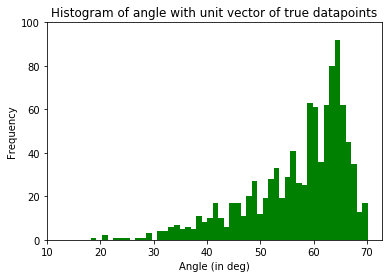

In [19]:
# Plotting histogram for true datapoints

n_1, bins_1, patches_1 = plt.hist(true_angles, bins=50, color='g')

plt.xlabel('Angle (in deg)')
plt.ylabel('Frequency')
plt.title('Histogram of angle with unit vector of true datapoints')

plt.xticks(np.arange(10, 80, step=10))
plt.yticks(np.arange(0, 101, step=20))

plt.show()

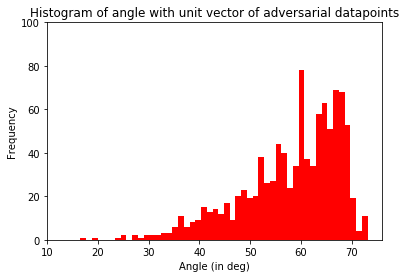

In [20]:
# Plotting histogram for adversarial datapoints

n_2, bins_2, patches_2 = plt.hist(adv_angles, bins=50, color='r')

plt.xlabel('Angle (in deg)')
plt.ylabel('Frequency')
plt.title('Histogram of angle with unit vector of adversarial datapoints')

plt.xticks(np.arange(10, 80, step=10))
plt.yticks(np.arange(0, 101, step=20))

plt.show()